In [1]:
import pandas as pd
# pre-processing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



In [31]:
import os
from pathlib import Path
# Current working directory
os.getcwd()

'/Users/nklabs/ml-assignment-2'

In [30]:
DATA_PATH = Path("data/bank-full.csv")
DATA_PATH

PosixPath('data/bank-full.csv')

In [2]:
df = pd.read_csv("data/bank-full.csv", sep=";")

In [3]:
## df.shape
## df.columns
df.head

<bound method NDFrame.head of        age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day

In [4]:
df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [32]:
df['job'].value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [5]:
## Step 3 : Encoding the Target

# Run this code only once. Or run the whole code from beginning. 
# Or else the encoding fails as yes and no are already substituted as 1 and 0 and re-running maps them to NaN
# Which effectively lends to fail the train-test split data

df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [6]:
df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [7]:
# Feature Groups
numeric_features = [
    'age', 'balance', 'day', 'duration',
    'campaign', 'pdays', 'previous'
]

categorical_features = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month', 'poutcome'
]

In [8]:
# Building Pre-processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [9]:
df['y'].isna().sum()

np.int64(0)

In [10]:
# Train-Test Split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
# Baseline Model - Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

In [12]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [13]:
# Evaluate
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score,
    f1_score, matthews_corrcoef
)

y_pred = logreg_pipeline.predict(X_test)
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.901249585314608
AUC: 0.9055740146044154
Precision: 0.6444833625218914
Recall: 0.34782608695652173
F1: 0.4518109269490485
MCC: 0.42605817794513523


In [14]:
# Create re-usable Evaluate function

from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score,
    f1_score, matthews_corrcoef
)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }

In [15]:
# Logistic regression

evaluate_model(logreg_pipeline, X_test, y_test)

{'Accuracy': 0.901249585314608,
 'AUC': np.float64(0.9055740146044154),
 'Precision': 0.6444833625218914,
 'Recall': 0.34782608695652173,
 'F1': 0.4518109269490485,
 'MCC': np.float64(0.42605817794513523)}

In [16]:
# Decision Tree

# Step - 1 Build the decision tree pipeline
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            random_state=42
        ))
    ]
)

# Step - 2 Train the model
dt_pipeline.fit(X_train, y_train)

# Step - 3 Evaluate
dt_results = evaluate_model(dt_pipeline, X_test, y_test)
dt_results

{'Accuracy': 0.8728298131151166,
 'AUC': np.float64(0.7008652802454508),
 'Precision': 0.4581818181818182,
 'Recall': 0.4763705103969754,
 'F1': 0.46709916589434664,
 'MCC': np.float64(0.39502678202261815)}

In [17]:
# KNN

# Step - 1 Build the decision tree pipeline

from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=5
        ))
    ]
)

# Step - 2 Train the model
knn_pipeline.fit(X_train, y_train)

# Step - 3 Evaluate
knn_results = evaluate_model(knn_pipeline, X_test, y_test)
knn_results

{'Accuracy': 0.8961627778392126,
 'AUC': np.float64(0.8277209275898927),
 'Precision': 0.5990016638935108,
 'Recall': 0.34026465028355385,
 'F1': 0.43399638336347196,
 'MCC': np.float64(0.40012752249162636)}

In [18]:
# Naive Bayes

# Step - 1 Modify the pre-processor, Create NB Specific pre-processor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

nb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Step - 2 Build Naive Bayes pipeline

from sklearn.naive_bayes import GaussianNB

nb_pipeline = Pipeline(
    steps=[
        ('preprocessor', nb_preprocessor),
        ('classifier', GaussianNB())
    ]
)

# Step - 3 Train & Evaluate
nb_pipeline.fit(X_train, y_train)

nb_results = evaluate_model(nb_pipeline, X_test, y_test)
nb_results



{'Accuracy': 0.8548048214088245,
 'AUC': np.float64(0.810079686273767),
 'Precision': 0.4059040590405904,
 'Recall': 0.5198487712665406,
 'F1': 0.45586406962287607,
 'MCC': np.float64(0.37735837569864067)}

In [19]:
# Random Forest

# Step - 1 Build Random Forest Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Step - 2 Train - Takes slightly more time and it is normal

rf_pipeline.fit(X_train, y_train)

# Step - 3 Evaluate
rf_results = evaluate_model(rf_pipeline, X_test, y_test)
rf_results

{'Accuracy': 0.906668141103616,
 'AUC': np.float64(0.9281971868330625),
 'Precision': 0.6636085626911316,
 'Recall': 0.4102079395085066,
 'F1': 0.5070093457943925,
 'MCC': np.float64(0.4748376730841785)}

In [20]:
# XGBoost

from xgboost import XGBClassifier

xgb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='auc',
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Step - 2 Train
xgb_pipeline.fit(X_train, y_train)

# Step - 3 Evaluate
xgb_results = evaluate_model(xgb_pipeline, X_test, y_test)
xgb_results


{'Accuracy': 0.9104279553245604,
 'AUC': np.float64(0.93497803655957),
 'Precision': 0.6593830334190232,
 'Recall': 0.4848771266540643,
 'F1': 0.5588235294117647,
 'MCC': np.float64(0.5177372908526476)}

In [21]:
# Create Results Dictionary

# Recompute LR results to avoid any stale state
lr_results = evaluate_model(logreg_pipeline, X_test, y_test)

results = {
    "Logistic Regression": lr_results,
    "Decision Tree": dt_results,
    "KNN": knn_results,
    "Naive Bayes": nb_results,
    "Random Forest": rf_results,
    "XGBoost": xgb_results
}

# Build a comparison DataFrame
results_df = pd.DataFrame(results).T  # transpose: models become rows

# Optional: round for readability
results_df_rounded = results_df.round(4)

# Sort by MCC first (primary), then AUC (secondary)
results_df_sorted = results_df_rounded.sort_values(by=["MCC", "AUC"], ascending=False)

results_df_sorted


,Accuracy,AUC,Precision,Recall,F1,MCC
XGBoost,0.9104,0.9350,0.6594,0.4849,0.5588,0.5177
Random Forest,0.9067,0.9282,0.6636,0.4102,0.5070,0.4748
Logistic Regression,0.9012,0.9056,0.6445,0.3478,0.4518,0.4261
KNN,0.8962,0.8277,0.5990,0.3403,0.4340,0.4001
Decision Tree,0.8728,0.7009,0.4582,0.4764,0.4671,0.3950
Naive Bayes,0.8548,0.8101,0.4059,0.5198,0.4559,0.3774


In [22]:
# Add rank column 

results_df_sorted = results_df_sorted.reset_index().rename(columns={"index": "Model"})
results_df_sorted.insert(0, "Rank", range(1, len(results_df_sorted) + 1))
results_df_sorted

,Rank,Model,Accuracy,AUC,Precision,Recall,F1,MCC
0,1,XGBoost,0.9104,0.9350,0.6594,0.4849,0.5588,0.5177
1,2,Random Forest,0.9067,0.9282,0.6636,0.4102,0.5070,0.4748
2,3,Logistic Regression,0.9012,0.9056,0.6445,0.3478,0.4518,0.4261
3,4,KNN,0.8962,0.8277,0.5990,0.3403,0.4340,0.4001
4,5,Decision Tree,0.8728,0.7009,0.4582,0.4764,0.4671,0.3950
5,6,Naive Bayes,0.8548,0.8101,0.4059,0.5198,0.4559,0.3774


In [23]:
results_df_sorted.to_csv("model_comparison_results.csv", index=False)

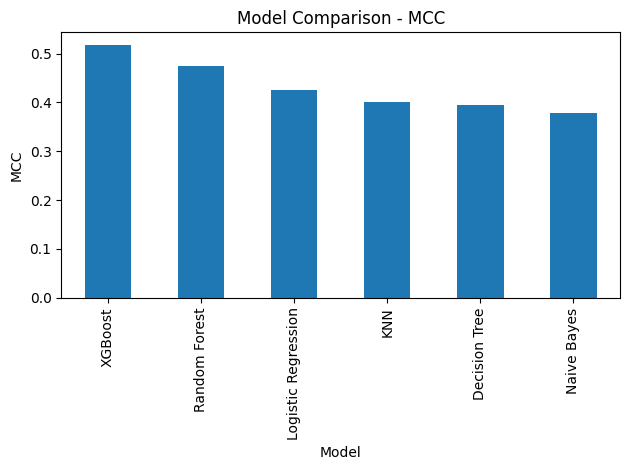

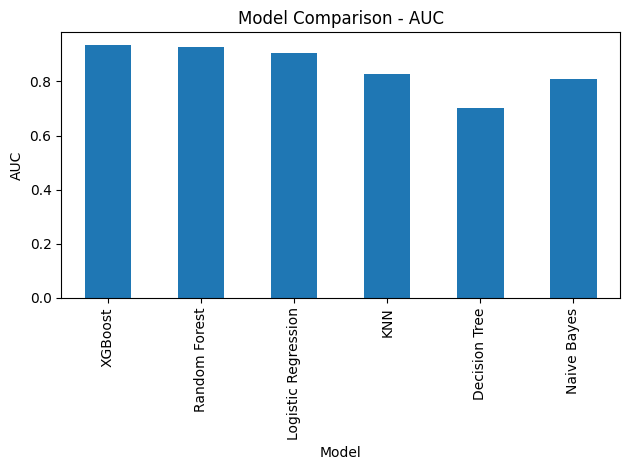

In [24]:
# Simple bar charts for MCC and AUC
import matplotlib.pyplot as plt

# MCC bar chart
results_df_sorted.plot(x="Model", y="MCC", kind="bar", legend=False)
plt.title("Model Comparison - MCC")
plt.ylabel("MCC")
plt.tight_layout()
plt.show()

# AUC bar chart
results_df_sorted.plot(x="Model", y="AUC", kind="bar", legend=False)
plt.title("Model Comparison - AUC")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

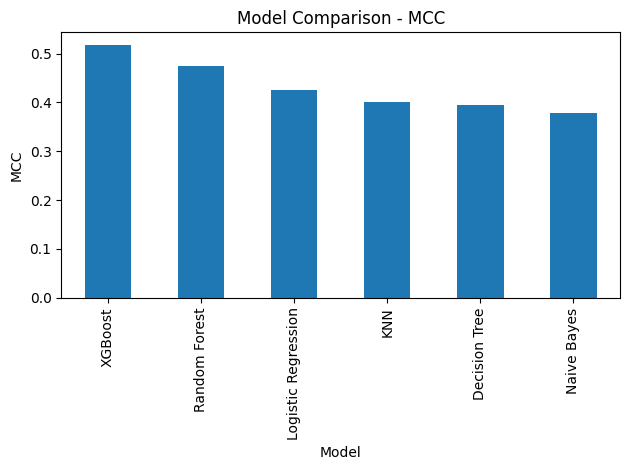

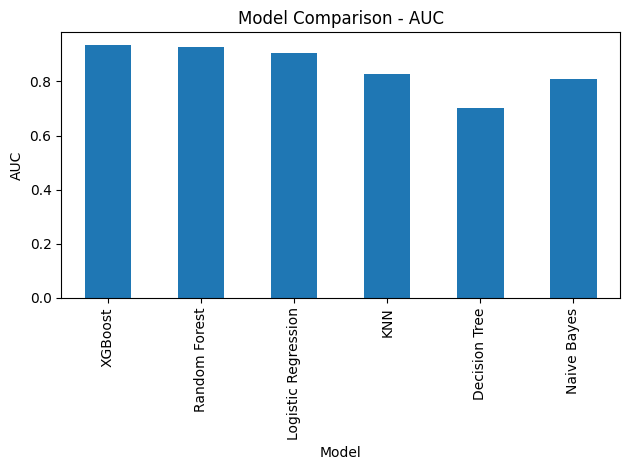

In [26]:
import pandas as pd

# Always recompute LR to avoid stale state
lr_results = evaluate_model(logreg_pipeline, X_test, y_test)

results = {
    "Logistic Regression": lr_results,
    "Decision Tree": dt_results,
    "KNN": knn_results,
    "Naive Bayes": nb_results,
    "Random Forest": rf_results,
    "XGBoost": xgb_results
}

results_df = pd.DataFrame(results).T  # models as rows
results_df = results_df.round(4)

# Sort: MCC primary, AUC secondary
results_df_sorted = results_df.sort_values(by=["MCC", "AUC"], ascending=False)

results_df_sorted

results_df_sorted_ranked = results_df_sorted.reset_index().rename(columns={"index": "Model"})
results_df_sorted_ranked.insert(0, "Rank", range(1, len(results_df_sorted_ranked) + 1))

results_df_sorted_ranked.to_csv("model_comparison_results.csv", index=False)

results_df_sorted_ranked

# MCC
results_df_sorted_ranked.plot(x="Model", y="MCC", kind="bar", legend=False)
plt.title("Model Comparison - MCC")
plt.ylabel("MCC")
plt.tight_layout()
plt.show()

# AUC
results_df_sorted_ranked.plot(x="Model", y="AUC", kind="bar", legend=False)
plt.title("Model Comparison - AUC")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

